# dataset  preparation

In [25]:

from dataset.dataset import *
from PIL import Image
import matplotlib.pyplot as plt

test_ds = RealEstate_dataset(info_root = 'dataset/RealEstate10K', data_root = 'dataset/RealEstate_data', mode = 'test')

In [26]:
img_s, img_t, K_s, R_rel, t_rel = test_ds[1]
    

# visualization for epipolar weight map

In [36]:
from models.epipolar import *
resolution = (128, 128)
K = K_s 
R = R_rel
t = t_rel
F = basic_matrix(K, R, t)
H, W = resolution

x_value = [100]
y_value = [60]
x_0 = x_value[0]
y_0 = y_value[0]
pj = torch.tensor([x_0,y_0,1.]).float()
line = F@pj     #等价于下面操作
# l2 = torch.matmul(F, pj)
# l2 = l2 / torch.norm(l2[:2])
line = line / torch.norm(line[:2])
print(line)

tensor([ -0.6108,  -0.7918, 114.8333])


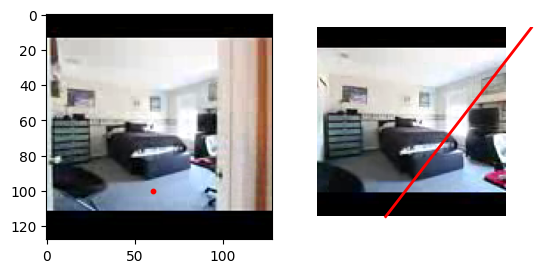

In [37]:
x1 = 0
y1 = (-line[2] - line[0] * x1) / line[1]
x2 = 128
y2 = (-line[2] - line[0] * x2) / line[1]

img1 = img_s.permute(1,2,0)
img2 = img_t.permute(1,2,0)

plt.subplot(1, 2, 1)
plt.imshow(img1)


plt.scatter(y_value, x_value,color='red', s=10)

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.plot([y1, y2], [x1, x2],  color='red', linewidth=2)
plt.axis('off')  # 关闭坐标轴
plt.show()

In [38]:
img1[120, 30, :]

tensor([0., 0., 0.])

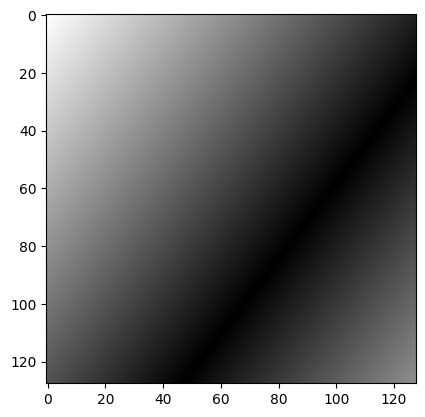

In [39]:
y, x = torch.meshgrid(torch.arange(H), torch.arange(W))
pixel_coordinates = torch.stack([y, x, torch.ones_like(x)], dim=2).view(-1, 3).float()  #pixel_cor(i,j, :)为[i, j, 1]
#print(pixel_coordinates.shape)
lines =  F@pixel_coordinates.t()        #[3, 128*128]
lines = lines / torch.norm(lines[:2], dim=0) 

pixel_coordinates = pixel_coordinates.view(-1, 128, 3)  #(128, 128, 3)
lines = lines.view(3, 128, -1)     #(3, 128, 128), lines[:, i, j] = pij 对应的极线参数

#lines = F @ pixel_coordinates.
W_Mat_x0_y0 = torch.abs(torch.matmul(pixel_coordinates, line))  #[128, 128]

plt.figure()
plt.imshow(W_Mat_x0_y0, cmap ='gray')       #pi：(10, 60)对应的极线l， 在view j上各个点距离l的距离
plt.show()

tensor([ -0.0618,   0.9981, -58.1013])


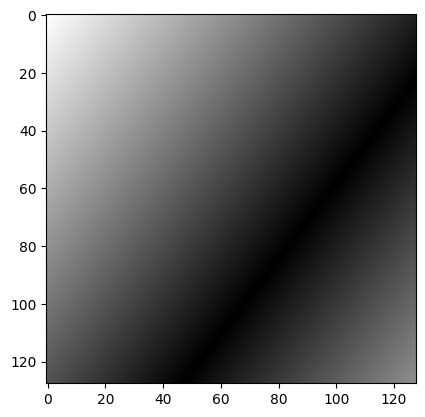

In [40]:
lines_a = lines.view(3, 128, -1)   #(3, 128, 128)
print(lines_a[:, 10,  60])           #lines_a[ :, i,,j]代表点(i,j)对应的极线
pixel_coordinates_flat = pixel_coordinates.view(-1, 3).permute(1,0) #([3, 128*128])
lines_flat = lines.view(3, -1).permute(1,0) #(128*128, 3)

W_Mat = torch.abs(torch.matmul(lines_flat, pixel_coordinates_flat)) #[16384, 16384]

#W_Mat = W_Mat.permute(1, 0)
index_x0_y0 = x_0*128 + y_0       #x=10, y=60
W_example = W_Mat[index_x0_y0, :].view(128, -1)

plt.figure()
plt.imshow(W_example,  cmap ='gray')       #pi：(10, 60)对应的极线l， 在view j上各个点距离l的距离
plt.show()

In [41]:

from models.epipolar_unet import *

W_Mat = epipolar_weight_Mat((128, 128), K_s, R_rel, t_rel)


In [42]:
W_Mat_res = 1. - sigmoid_func(50.0*(W_Mat- 0.7))

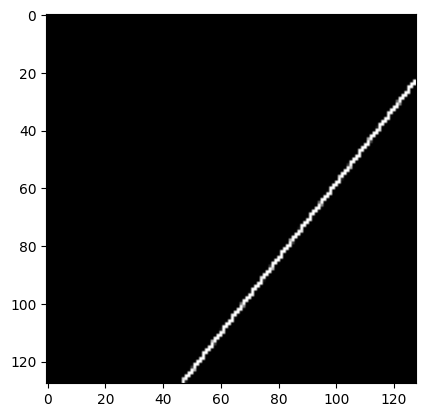

In [43]:
example = W_Mat_res[index_x0_y0].view(-1, 128)
plt.figure()
plt.imshow(example,  cmap ='gray') 
plt.show()